#### Lecture 6 - Linear systems

Matrix from C&C Case Study 12.1 - system of 5 reactors with unknown concentrations.

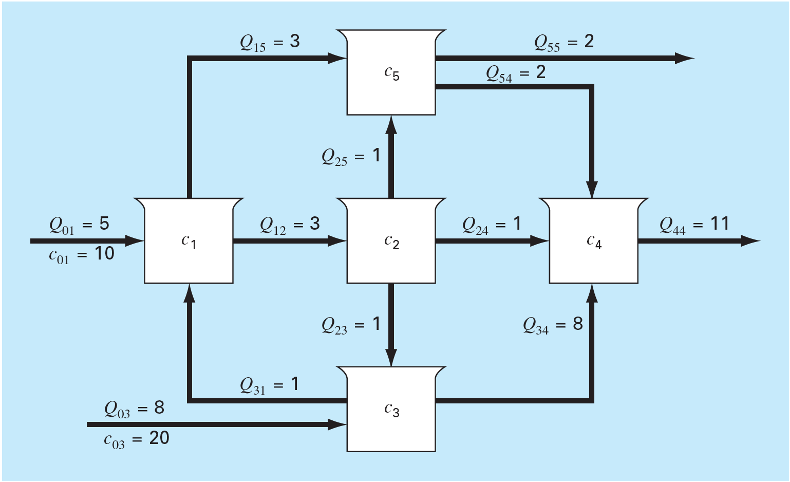

- Check if singular using determinant
- Perform LU decomposition without partial pivoting
- Compare to scipy.linalg.lu
- Solve for unknowns and compare to scipy.linalg.solve
- Change b (new concentration inputs) and solve again without repeating the row elimination

In [4]:
import numpy as np
import scipy.linalg as sl

A = np.array([[6, 0, -1, 0, 0],
              [-3, 3, 0, 0, 0],
              [0, -1, 9, 0, 0],
              [0, -1, -8, 11, -2],
              [-3, -1, 0, 0, 4]])

b = np.array([50, 0, 160, 0, 0]).T

print(A.shape) # check dimensions of array
print(b.shape)
n = A.shape[0]

(5, 5)
(5,)


In [5]:
# the values are entered as ints, change to floats
print(A.dtype)
A = A.astype(float)
b = b.astype(float)
print(A.dtype)

int64
float64


In [6]:
# check for singular matrix (det = 0)
sl.det(A)

6996.0

In [15]:
# LU decomposition
# this does not include partial pivoting and may encounter divide by zero errors
# see C&C Figure 10.2 for pseudocode for LU with partial pivoting
U = A.copy()
L = np.eye(n)

for k in range(n-1):
    for i in range(k+1,n): 
        L[i,k] = U[i,k] / U[k,k] # multiplying factor
        U[i,:] = U[i,:] - L[i,k] * U[k,:] # modify row i based on pivot row k

In [8]:
# check answers
# set precision for printing - easier to compare matrices
# suppress=True turns off scientific notation for small numbers
np.set_printoptions(precision=3, suppress=True)
print(L)

[[ 1.     0.     0.     0.     0.   ]
 [-0.5    1.     0.     0.     0.   ]
 [ 0.    -0.333  1.     0.     0.   ]
 [ 0.    -0.333 -0.925  1.     0.   ]
 [-0.5   -0.333 -0.075  0.     1.   ]]


In [9]:
print(U)

[[ 6.     0.    -1.     0.     0.   ]
 [ 0.     3.    -0.5    0.     0.   ]
 [ 0.     0.     8.833  0.     0.   ]
 [ 0.     0.     0.    11.    -2.   ]
 [ 0.     0.     0.     0.     4.   ]]


In [10]:
print(A)

[[ 6.  0. -1.  0.  0.]
 [-3.  3.  0.  0.  0.]
 [ 0. -1.  9.  0.  0.]
 [ 0. -1. -8. 11. -2.]
 [-3. -1.  0.  0.  4.]]


In [11]:
print(L @ U) # should equal the original A

[[ 6.  0. -1.  0.  0.]
 [-3.  3.  0.  0.  0.]
 [ 0. -1.  9.  0.  0.]
 [ 0. -1. -8. 11. -2.]
 [-3. -1.  0.  0.  4.]]


In [17]:
# easier way to check if they are equal
# https://numpy.org/doc/stable/reference/generated/numpy.allclose.html
np.allclose(A, L @ U)

True

In [18]:
# compare to scipy.linalg built in function lu()
# the permute keyword makes the result comparable to ours
L_, U_ = sl.lu(A, permute_l=True)
np.allclose(L, L_)
np.allclose(U, U_)

True

Next we need to solve for the unknowns $\mathbf{c}$ given RHS vector $\mathbf{b}$. Two steps: 
- Solve $\mathbf{Ld} = \mathbf{b}$ for the intermediate vector $\mathbf{d}$ using forward substitution
- Solve $\mathbf{Ux} = \mathbf{d}$ using back substitution

In [20]:
# forward substitution
d = np.zeros(n)
d[0] = b[0] / L[0,0]

for i in range(1,n):
    d[i] = (b[i] - L[i,:] @ d) / L[i,i]

# back substitution
x = np.zeros(n)
x[-1] = d[-1] / U[-1,-1] # index -1 for last element

for i in range(n-2,-1,-1): # loop backward starting from second-to-last row
    x[i] = (d[i] - U[i,i+1:n] @ x[i+1:n]) / U[i,i]  

print('Our answer: ', x)
print('Matches Scipy? ', np.allclose(x, sl.solve(A,b)))

Our answer:  [11.509 11.509 19.057 16.998 11.509]
Matches scipy?  True


Now if the input concentration $\mathbf{b}$ changes, Gauss elimination would require the row elimination to be repeated with $O(n^3)$ operations. However, since we already have the LU decomposition, we only need to perform the forward/back substitution steps. This is $O(n^2)$ operations.

For example, say concentration $c_{01}=20$ and $c_{03}=10$. Using mass balance, this would lead to a new vector $\mathbf{b} = [100, 0, 80, 0, 0]^T$. We are only changing the inputs, so the matrix $\mathbf{A}$ does not change.

In [22]:
b2 = np.array([100, 0, 80, 0, 0]).T

# repeat the steps above to solve (could write this in a function)

# forward substitution
d = np.zeros(n)
d[0] = b2[0] / L[0,0]

for i in range(1,n):
    d[i] = (b2[i] - L[i,:] @ d) / L[i,i]

# back substitution
x = np.zeros(n)
x[-1] = d[-1] / U[-1,-1] # index -1 for last element

for i in range(n-2,-1,-1): # loop backward starting from second-to-last row
    x[i] = (d[i] - U[i,i+1:n] @ x[i+1:n]) / U[i,i]  

print('Our answer: ', x)
print('Matches Scipy? ', np.allclose(x, sl.solve(A,b2)))

Our answer:  [18.491 18.491 10.943 13.002 18.491]
Matches Scipy?  True


The steady-state concentrations have increased in reactors 1, 2, and 5. The concentration has decreased in reactors 3 and 4. It would be difficult to guess this just by looking at the system diagram and flowrates. In the next lecture we will work on more formal ways to analyze the change in system states as a linear function of the forcing using the matrix inverse.